In [1]:
import requests
import json
import time
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, RandomForestRegressor
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, auc, roc_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from scipy import stats
import seaborn as sns
import tensorflow as tf
from sklearn import metrics
from datetime import datetime
import xgboost as xgb
import pickle

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
df = pd.read_csv('train.csv')
weather = pd.read_csv('weather.csv')
spray = pd.read_csv('spray.csv')
test = pd.read_csv('test.csv')

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
Date                      10506 non-null object
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
dtypes: float64(2), int64(4), object(6)
memory usage: 985.0+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
Id                        116293 non-null int64
Date                      116293 non-null object
Address                   116293 non-null object
Species                   116293 non-null object
Block                     116293 non-null int64
Street                    116293 non-null object
Trap                      116293 non-null object
AddressNumberAndStreet    116293 non-null object
Latitude                  116293 non-null float64
Longitude                 116293 non-null float64
AddressAccuracy           116293 non-null int64
dtypes: float64(2), int64(3), object(6)
memory usage: 9.8+ MB


In [6]:
def clean_train_data(df):
    
    # map df dataset with weather dataset
    mask3 = np.power((df['Latitude']-41.995),2)+ np.power((df['Longitude']-(-87.933)),2) <= \
            np.power((df['Latitude']-41.786),2)+ np.power((df['Longitude']-(-87.752)),2)
    mask4 = np.power((df['Latitude']-41.995),2)+ np.power((df['Longitude']-(-87.933)),2) > \
            np.power((df['Latitude']-41.786),2)+ np.power((df['Longitude']-(-87.752)),2)
    df.loc[mask3,'weather_station'] = 1
    df.loc[mask4,'weather_station'] = 2
    df_weather = df.join(weather.set_index(['Date','Station']), on=(['Date','weather_station']), how='left')
    
    # map df_weather dataset with spray dataset
    date_format = "%Y-%m-%d"
    date_formated_df = []
    date_formated_spray = []
    for i in df_weather['Date']:
        date_formated_df.append(datetime.strptime(i, date_format))
    for i in spray['Date']:
        date_formated_spray.append(datetime.strptime(i, date_format))
    date_formated_spray = set(date_formated_spray)
    date_formated_spray = list(date_formated_spray)
    days_after_spray = []
    for i in date_formated_df:
        delta = []
        for n in date_formated_spray:
            if (i - n).days > 0:
                delta.append((i - n).days)
        if len(delta) != 0:
            days = np.min(delta)
        else:
            days = 0
        days_after_spray.append(days)
    df_weather['days_after_spray'] = days_after_spray
    
    # clean up the total dataset 
    df_total = df_weather
    
    #fix NumMosquitos column
    df_total['NumMosquitos_sum'] = np.nan #create sum column
    #fill sum column with sum of matching rows
    df_total['NumMosquitos_sum'].fillna(df_total.groupby(['Date','Trap','Species'])['NumMosquitos'].transform('sum'), inplace=True)
    df_total.drop(['NumMosquitos'], axis=1, inplace=True) #drop old column
    df_total.drop_duplicates(inplace=True) #drop duplicated rows 
    df_total.reset_index(inplace=True) #reset index 
    
    #create ordinal date column
    df_total['Date'] = pd.to_datetime(df_total['Date'])
    df_total['ordinal_date'] = df_total['Date'].map(lambda x: x.toordinal())
    
    #create month/day for time of year 
    df_total['month_day'] = df_total['Date'].dt.month + df_total['Date'].map(lambda x: .5 if x.day > 15 else 0)
    
    ## drop useless columns
    ## different for train and test dataset because test data doesn't include 'NumMosquitos' column
    ## and test data has "Id" column that need to be dropped
    
    df_total = df_total.drop(['Date','Address','Block','Street','Trap','AddressNumberAndStreet',\
              'AddressAccuracy','weather_station','Depart','CodeSum','Depth',\
              'Water1','SnowFall', 'Sunrise', 'Sunset', 'index'],axis=1)
              # NumMosquitos and CodeSum may still helpful (test data doesn't include 'NumMosquitos' column)
              #**changed this to keep NumMosquitos
    
    ## deal with the missing value of the useful columns
    mask5 = (df_total.PrecipTotal == '  T')| (df_total.PrecipTotal =='M')
    mask6 = df_total.WetBulb == 'M'
    mask7 = df_total.StnPressure == 'M'
    df_total.loc[mask5,'PrecipTotal'] = 0.00
    df_total.loc[mask6,'WetBulb'] = round((df_total[df_total.WetBulb!='M']['WetBulb']).astype('int').mean())
    df_total.loc[mask7,'StnPressure'] = round((df_total[df_total.StnPressure!='M']['StnPressure']).astype('float').mean(),2)
    
    ## change the datatype to correct one
    df_total[['Tavg','WetBulb','Heat','Cool']] = df_total[['Tavg','WetBulb','Heat','Cool']].astype(int)
    df_total[['PrecipTotal','StnPressure','SeaLevel','AvgSpeed']] = \
    df_total[['PrecipTotal','StnPressure','SeaLevel','AvgSpeed']].astype(float)
    
    #computer rolling averages 
    for i in [3,5,10,14,21]: #set intervals for rolling average calculation
        for j in ['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 'Cool',    #columns to compute rolling averages for
                  'PrecipTotal', 'StnPressure', 'SeaLevel','ResultSpeed', 'ResultDir', 'AvgSpeed']:
            df_total[j + str(i)] = df_total[j].rolling(window=i, min_periods=int(i/5)).mean() #create column with interval for each computation
                                                                                #min_periods allows for computing these and not getting NaN values
                                                                                #for reasonable amount of missing data
    
    
    #fill na's
    df_total.fillna(method='backfill', inplace=True)
    
    
    # return cleaned dataframe

    return df_total

In [7]:
def clean_test_data(df):
    
    # map df dataset with weather dataset
    mask3 = np.power((df['Latitude']-41.995),2)+ np.power((df['Longitude']-(-87.933)),2) <= \
            np.power((df['Latitude']-41.786),2)+ np.power((df['Longitude']-(-87.752)),2)
    mask4 = np.power((df['Latitude']-41.995),2)+ np.power((df['Longitude']-(-87.933)),2) > \
            np.power((df['Latitude']-41.786),2)+ np.power((df['Longitude']-(-87.752)),2)
    df.loc[mask3,'weather_station'] = 1
    df.loc[mask4,'weather_station'] = 2
    df_weather = df.join(weather.set_index(['Date','Station']), on=(['Date','weather_station']), how='left')

    # map df_weather dataset with spray dataset
    date_format = "%Y-%m-%d"
    date_formated_df = []
    date_formated_spray = []
    for i in df_weather['Date']:
        date_formated_df.append(datetime.strptime(i, date_format))
    for i in spray['Date']:
        date_formated_spray.append(datetime.strptime(i, date_format))
    date_formated_spray = set(date_formated_spray)
    date_formated_spray = list(date_formated_spray)
    days_after_spray = []
    for i in date_formated_df:
        delta = []
        for n in date_formated_spray:
            if (i - n).days > 0:
                delta.append((i - n).days)
        if len(delta) != 0:
            days = np.min(delta)
        else:
            days = 0
        days_after_spray.append(days)
    df_weather['days_after_spray'] = days_after_spray
    
    # clean up the total dataset 
    df_total = df_weather
    
    #create ordinal date column
    df_total['Date'] = pd.to_datetime(df_total['Date'])
    df_total['ordinal_date'] = df_total['Date'].map(lambda x: x.toordinal())
    
    #create month/day for time of year 
    df_total['month_day'] = df_total['Date'].dt.month + df_total['Date'].map(lambda x: .5 if x.day > 15 else 0)
    
    ## drop useless columns
    ## different for train and test dataset because test data doesn't include 'NumMosquitos' column
    ## and test data has "Id" column that need to be dropped
    
    ### for train dataset
#     df_total = df_total.drop(['Date','Address','Block','Street','Trap','AddressNumberAndStreet',\
#               'AddressAccuracy','weather_station','Depart','CodeSum','Depth',\
#               'Water1','SnowFall','Sunrise','Sunset','NumMosquitos'],axis=1)
                 
                 # NumMosquitos and CodeSum may still helpful (test data doesn't include 'NumMosquitos' column)
    
    ### for test dataset
    df_total = df_total.drop(['Id','Date','Address','Block','Street','Trap','AddressNumberAndStreet',\
               'AddressAccuracy','weather_station','Depart','CodeSum','Depth',\
               'Water1','SnowFall','Sunrise','Sunset'],axis=1)
    
    
    ## deal with the missing value of the useful columns
    mask5 = (df_total.PrecipTotal == '  T')| (df_total.PrecipTotal =='M')
    mask6 = df_total.WetBulb == 'M'
    mask7 = df_total.StnPressure == 'M'
    df_total.loc[mask5,'PrecipTotal'] = 0.00
    df_total.loc[mask6,'WetBulb'] = round((df_total[df_total.WetBulb!='M']['WetBulb']).astype('int').mean())
    df_total.loc[mask7,'StnPressure'] = round((df_total[df_total.StnPressure!='M']['StnPressure']).astype('float').mean(),2)
    
    ## change the datatype to correct one
    df_total[['Tavg','WetBulb','Heat','Cool']] = df_total[['Tavg','WetBulb','Heat','Cool']].astype(int)
    df_total[['PrecipTotal','StnPressure','SeaLevel','AvgSpeed']] = \
    df_total[['PrecipTotal','StnPressure','SeaLevel','AvgSpeed']].astype(float)
    
    #computer rolling averages 
    for i in [3,5,10,14,21]: #set intervals for rolling average calculation
        for j in ['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 'Cool',    #columns to compute rolling averages for
                  'PrecipTotal', 'StnPressure', 'SeaLevel','ResultSpeed', 'ResultDir', 'AvgSpeed']:
            df_total[j + str(i)] = df_total[j].rolling(window=i, min_periods=int(i/5)).mean() #create column with interval for each computation
                                                                                #min_periods allows for computing these and not getting NaN values
                                                                                #for reasonable amount of missing data
    #fill na's
    df_total.fillna(method='backfill', inplace=True)

    
    
    # create polynomial features
    
    ## for train dataset
#     y = df_total['WnvPresent']
#     X = df_total.drop('WnvPresent',axis=1)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.15)
#     poly = PolynomialFeatures(include_bias=False,degree=2)
#     X_train_poly = poly.fit_transform(X_train)
#     X_test_poly = poly.transform(X_test)
#     X_train=pd.DataFrame(X_train_poly,columns=poly.get_feature_names(X_train.columns))
#     X_test=pd.DataFrame(X_test_poly,columns=poly.get_feature_names(X_test.columns))
    
    ## for test dataset
#     poly = PolynomialFeatures(include_bias=False,degree=2)
#     df_total_poly = poly.fit_transform(df_total)
#     df_total=pd.DataFrame(df_total_poly,columns=poly.get_feature_names(df_total.columns))
    
    # return cleaned dataframe
    
    ## for train dataset, return X_train and X_test data
#     return X_train, X_test
    
    ## for test dataset, return df_total
    return df_total

In [8]:
test_clean = clean_test_data(test)
test_clean.shape

(116293, 84)

In [9]:
train_clean = clean_train_data(df)
train_clean.shape

(8610, 86)

In [10]:
train_clean['WnvPresent'].value_counts(normalize=True)

0    0.946922
1    0.053078
Name: WnvPresent, dtype: float64

# project nummosquitos

In [11]:
col_list = ['Species', 'NumMosquitos_sum', 'WnvPresent']
numerical_columns = [cols for cols in train_clean.columns if cols not in col_list]
object_columns = ['Species']

In [27]:
# Class for selecting multiple features    
class SampleExtractor(BaseEstimator, TransformerMixin):
    """Takes in variable names as a **list**"""
    def __init__(self, vars):
        self.vars = vars  # e.g. pass in a column names to extract
    def transform(self, X, y=None):
        if len(self.vars) > 1:
            return pd.DataFrame(X[self.vars]) # where the actual feature extraction happens
        else:
            return pd.Series(X[self.vars[0]])
    def fit(self, X, y=None):
        return self  # generally does nothing

In [28]:
#create x and y columns for num mosquitos
X_mos = train_clean[[cols for cols in train_clean.columns if cols != 'NumMosquitos_sum' and cols != 'WnvPresent']]
y_mos = train_clean['NumMosquitos_sum']

#TTS
X_train_mos, X_test_mos, y_train_mos, y_test_mos = train_test_split(X_mos, y_mos, random_state=40, test_size=0.15)

In [29]:
ss= StandardScaler()
cvec = CountVectorizer()

numerical_pipe = Pipeline([
    ('selector', SampleExtractor(numerical_columns)),
    ('ss', ss)
])

object_pipe = Pipeline([
    ('selector', SampleExtractor(object_columns)),
    ('cvec', cvec)
])

# Merge pipeline

merge = FeatureUnion([
    ('numerical', numerical_pipe),
    ('object', object_pipe)
])

In [36]:
pip_xgb = Pipeline([
    ('merger', merge),
    ('xgb', xgb.XGBRegressor())
    
])

params_xgb = {
    'xgb__n_estimators':[150, 175, 200],
    'xgb__learning_rate': [.01, .1, .15],
    'xgb__max_depth': [3,5,7]
}
gs2 = GridSearchCV(pip_xgb,param_grid=params_xgb)
gs2.fit(X_train_mos,y_train_mos)
print('best cv score', gs2.best_score_)
print('best paramas', gs2.best_params_)
print('test score', gs2.score(X_test_mos, y_test_mos))

best cv score 0.4608321954209913
best paramas {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 175}
test score 0.7590571819787055


In [37]:
#fit model on all training data
mos_model = gs2.best_estimator_
mos_model.fit(X_mos, y_mos)

Pipeline(memory=None,
     steps=[('merger', FeatureUnion(n_jobs=1,
       transformer_list=[('numerical', Pipeline(memory=None,
     steps=[('selector', SampleExtractor(vars=['Latitude', 'Longitude', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'Resul...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [50]:
#predict mosquito counts for test data
test_clean['project_mos'] = mos_model.predict(test_clean)

NameError: name 'mos_model' is not defined

In [40]:
#predict mosquito counts for train data 
train_clean['project_mos'] = mos_model.predict(train_clean)

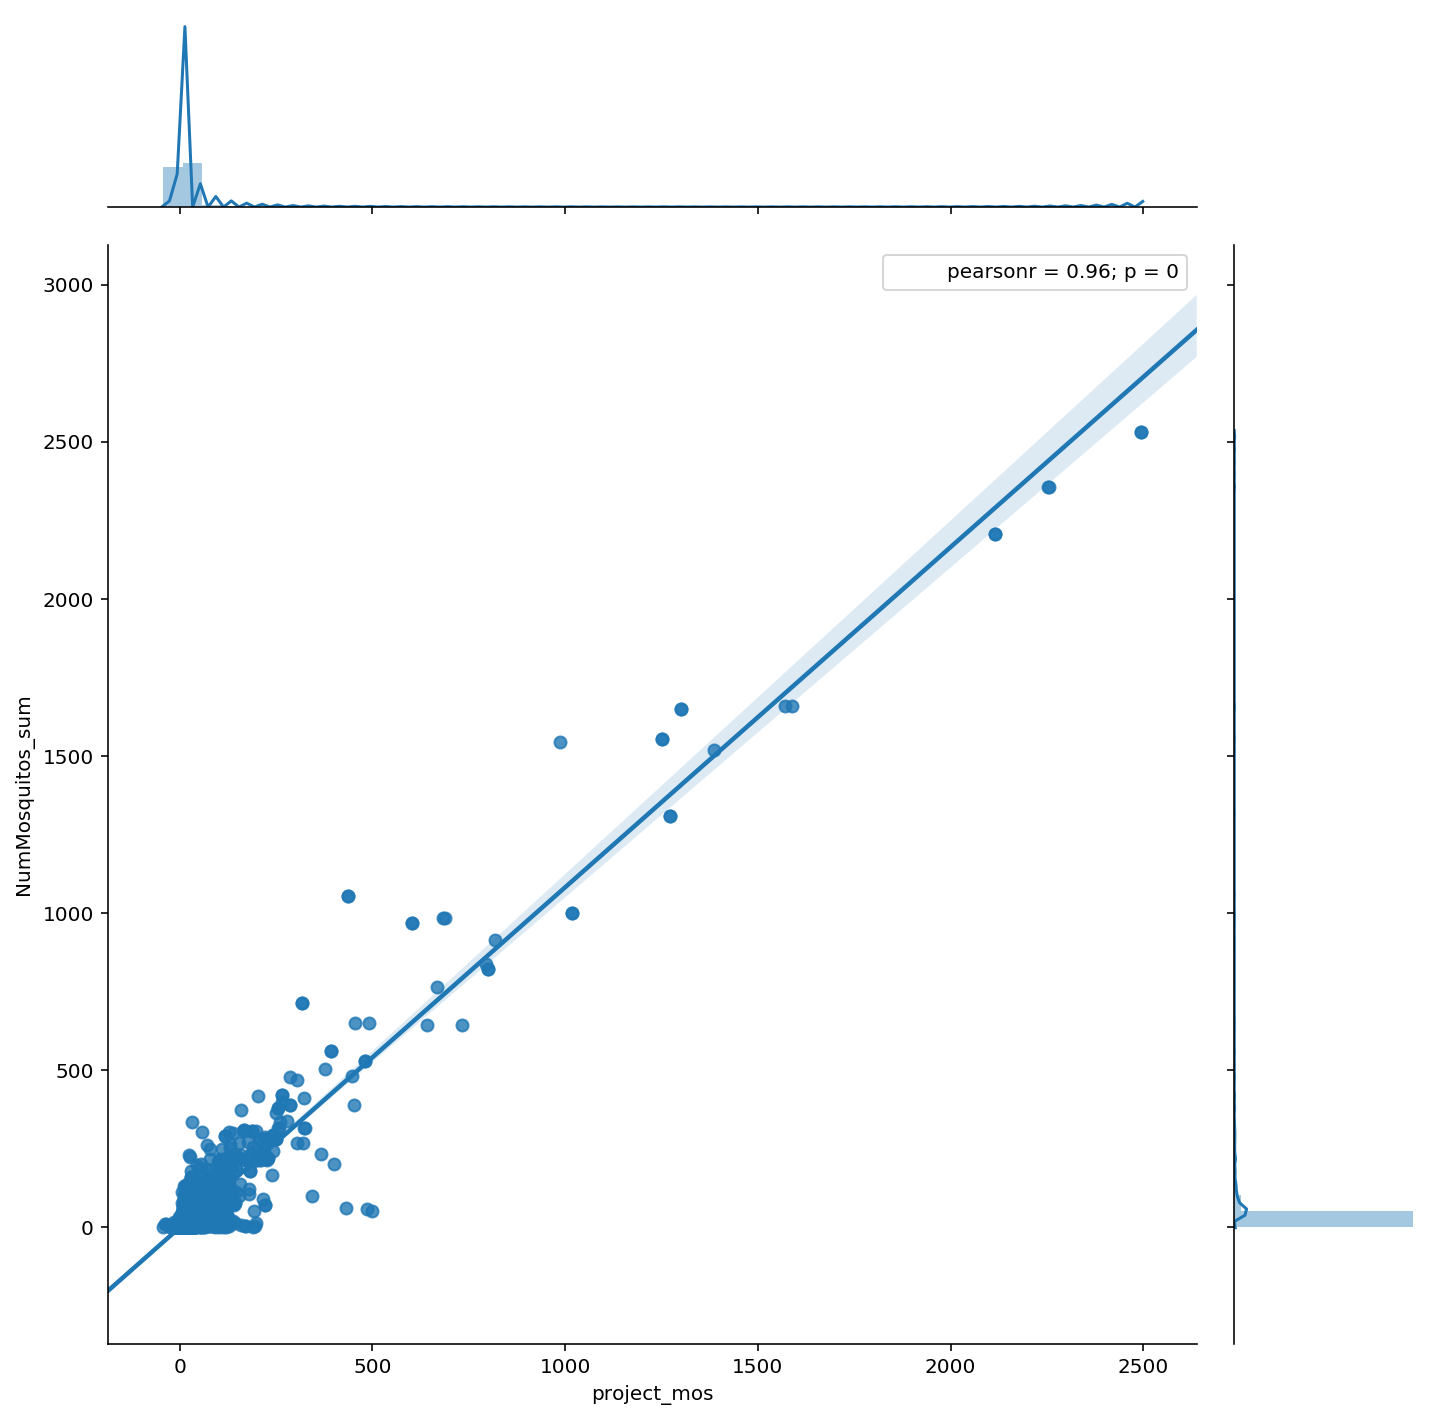

In [41]:
#plot predicted counts and actual for train data b
sns.jointplot('project_mos', 'NumMosquitos_sum', kind='reg', data= train_clean, size=10);

In [45]:
modelfilename= 'mos_model.sav'

In [46]:
pickle.dump(mos_model, open(modelfilename, 'wb'))

In [17]:
loaded_model = pickle.load(open('mos_model.sav', 'rb'))

In [19]:
loaded_model.score(X_test_mos, y_test_mos)

0.9250519701691257

In [51]:
#predict mosquito counts for test data
test_clean['project_mos'] = loaded_model.predict(test_clean)

In [52]:
#predict mosquito counts for train data 
train_clean['project_mos'] = loaded_model.predict(train_clean)

### build the classficiation model

In [53]:
from sklearn.utils import resample

## Separate majority and minority classes
df_majority = train_clean[train_clean.WnvPresent==0]
df_minority = train_clean[train_clean.WnvPresent==1]
 
## Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=8153,    # to match majority class
                                 random_state=42) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.WnvPresent.value_counts()

1    8153
0    8153
Name: WnvPresent, dtype: int64

In [54]:
df_upsampled.head()

,Species,Latitude,Longitude,WnvPresent,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,days_after_spray,NumMosquitos_sum,ordinal_date,month_day,Tmax3,Tmin3,Tavg3,DewPoint3,WetBulb3,Heat3,Cool3,PrecipTotal3,StnPressure3,SeaLevel3,ResultSpeed3,ResultDir3,AvgSpeed3,Tmax5,Tmin5,Tavg5,DewPoint5,WetBulb5,Heat5,Cool5,PrecipTotal5,StnPressure5,SeaLevel5,ResultSpeed5,ResultDir5,AvgSpeed5,Tmax10,Tmin10,Tavg10,DewPoint10,WetBulb10,Heat10,Cool10,PrecipTotal10,StnPressure10,SeaLevel10,ResultSpeed10,ResultDir10,AvgSpeed10,Tmax14,Tmin14,Tavg14,DewPoint14,WetBulb14,Heat14,Cool14,PrecipTotal14,StnPressure14,SeaLevel14,ResultSpeed14,ResultDir14,AvgSpeed14,Tmax21,Tmin21,Tavg21,DewPoint21,WetBulb21,Heat21,Cool21,PrecipTotal21,StnPressure21,SeaLevel21,ResultSpeed21,ResultDir21,AvgSpeed21,project_mos
0,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,0,88,60,74,58,65,0,9,0.0,29.39,30.11,5.8,18,6.5,0,1.0,732825,5.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,11.576159
1,CULEX RESTUANS,41.954690,-87.800991,0,88,60,74,58,65,0,9,0.0,29.39,30.11,5.8,18,6.5,0,1.0,732825,5.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,4.411975
2,CULEX RESTUANS,41.994991,-87.769279,0,88,60,74,58,65,0,9,0.0,29.39,30.11,5.8,18,6.5,0,1.0,732825,5.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,-0.369628
3,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,0,88,60,74,58,65,0,9,0.0,29.39,30.11,5.8,18,6.5,0,1.0,732825,5.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,14.602871
4,CULEX RESTUANS,41.974089,-87.824812,0,88,60,74,58,65,0,9,0.0,29.39,30.11,5.8,18,6.5,0,4.0,732825,5.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,6.478076


In [55]:
y = df_upsampled['WnvPresent']
X = df_upsampled.drop(['WnvPresent', 'NumMosquitos_sum'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.15)

In [ ]:
# random forest is OK
pip1 = Pipeline([
    ('merger', merge),
    ('rf', RandomForestClassifier())
    
])
params1 = {
    'rf__n_estimators':[5,10,20],
    'rf__max_features': ["auto","sqrt","log2"],
    'rf__max_depth': [None,10,20]
}
gs3 = GridSearchCV(pip1,param_grid=params1)
gs3.fit(X_train,y_train)
print('best cv score', gs3.best_score_)
print('best paramas', gs3.best_params_)
print('test score', gs3.score(X_test, y_test))

In [ ]:
# create a confusion matrix
y_hat = gs3.predict(X_test)
confusion_matrix(y_test,y_hat)

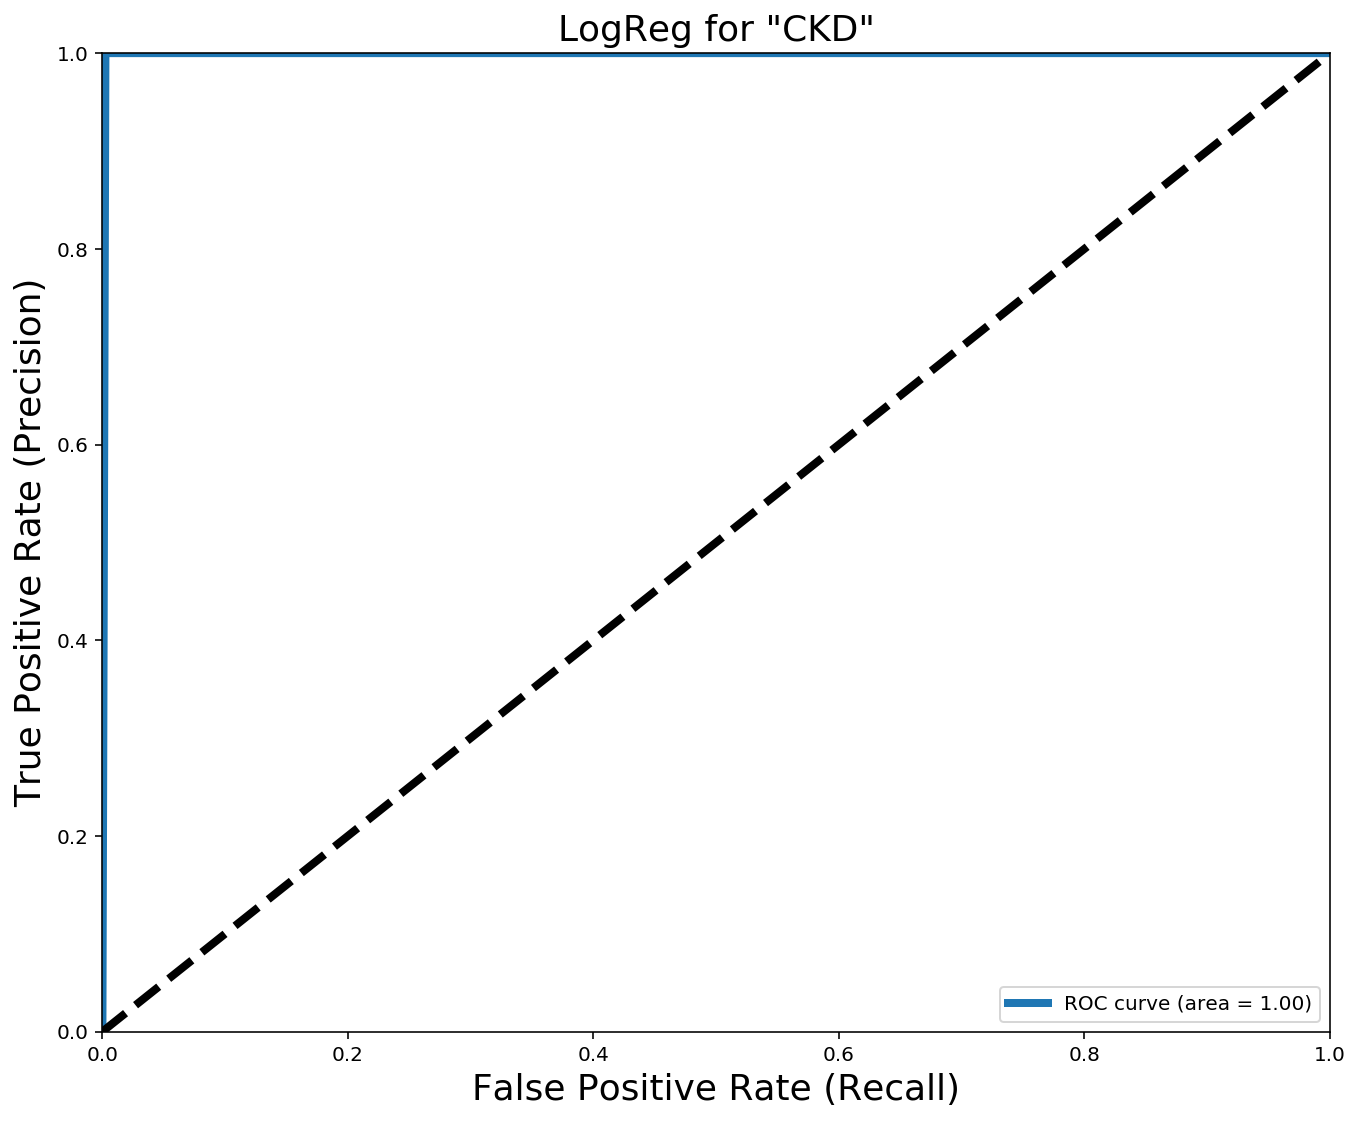

In [58]:
y_pred = gs3.predict(X_test)
FPR, TPR, threshold = roc_curve(y_test, y_pred)
ROC_AUC = auc(FPR, TPR)

plt.figure(figsize=[11,9])
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (Recall)', fontsize=18)
plt.ylabel('True Positive Rate (Precision)', fontsize=18)
plt.title('LogReg for "CKD"', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [ ]:
gs3.fit(X, y)

In [59]:
test_clean.shape

(116293, 85)

In [60]:
test_pred = gs3.predict(test_clean)

In [61]:
test_pred.shape

(116293,)

In [62]:
test_pred = pd.DataFrame(test_pred)

In [63]:
test_pred['Id'] = [i for i in range(1,116294)]
test_pred['WnvPresent'] = test_pred[0]

In [64]:
test_pred.drop([0],axis=1,inplace=True)

In [65]:
test_pred.tail()

,Id,WnvPresent
116288,116289,0
116289,116290,0
116290,116291,0
116291,116292,0
116292,116293,0


In [66]:
test_pred['WnvPresent'].value_counts()

0    116177
1       116
Name: WnvPresent, dtype: int64

In [67]:
test_pred.to_csv('test_pred_3.csv',index=False)

In [ ]:
# train test split 
y = train_clean['WnvPresent']
X = train_clean.drop(['WnvPresent', 'NumMosquitos'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y,
                                                    random_state=42)


# Using RandomForestClassifier
rfc = RandomForestClassifier(random_state=19)
bbc = BalancedBaggingClassifier(base_estimator=rfc,
                                random_state=10)
bbc.fit(X_train,y_train)

bbc_predict = bbc.predict(X_test)
bbc_score = recall_score(y_test, bbc_predict)

print ("BBC Test Score:", bbc_score)

bbc_confusion = pd.DataFrame(np.array(confusion_matrix(y_test, bbc_predict)),
                         index = ['is_not_abnormal', 'is_abnormal'],
                        columns=['predicted_not_abnormal','predicted_abnormal'])
bbc_confusion

bbc_params = {
    'n_estimators':np.arange(5,20),
    'warm_start': [True, False]
#     'max_samples': [1,2]
#     'max_features': np.arange(1,10)
}

bbc_gs = GridSearchCV(bbc,
                     param_grid=bbc_params,
                     scoring='recall',
                     cv = 10)

bbc_gs.fit(X_train,y_train)
bbc_gs_score = bbc_gs.score(X_test, y_test)

print("Best Params: ", bbc_gs.best_params_)
print ("BBC Test Score:", bbc_gs_score)

## Clean and Predict test data set

# additional models (optional)

In [ ]:
# svm
gamma_range = [0.001]
C_range = [1]
kernel_range = ['rbf', 'sigmoid', 'linear', 'poly']

params3 = dict(gamma=gamma_range, kernel=kernel_range, C=C_range)

clf = svm.SVC()
gs3 = GridSearchCV(clf, params3, scoring="accuracy", verbose=0)
gs3.fit(X_train,y_train)

In [ ]:
print('best cv score', gs3.best_score_)
print('best paramas', gs3.best_params_)
print('test score', gs3.score(X_test, y_test))

In [ ]:
# svm using unbalanced sample and use class_weight = 'WnvPresent' to penalize mistakes on the minority class 
# by an amount proportional to how under-represented it is.
y = train_clean['WnvPresent']
X = train_clean.drop('WnvPresent',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.15)

gamma_range = [0.001]
C_range = [1]
kernel_range = ['linear']
class_weight=['balanced']

params4 = dict(gamma=gamma_range, kernel=kernel_range, C=C_range, class_weight=class_weight)

clf = svm.SVC()
gs4 = GridSearchCV(clf, params4, scoring="accuracy", verbose=0)
gs4.fit(X_train,y_train)

print('best cv score', gs4.best_score_)
print('best paramas', gs4.best_params_)
print('test score', gs4.score(X_test, y_test))

In [ ]:
# logistic regression is bad?
pip2 = Pipeline([
    ('ss', StandardScaler()), 
    ('lr', LogisticRegression())
])
params2 = {
    'lr__penalty':['l1','l2'],
    'lr__C':[0.1,0.5,0.9]
}
gs2 = GridSearchCV(pip2,param_grid=params2)
gs2.fit(X_train,y_train)
print('best cv score', gs2.best_score_)
print('best paramas', gs2.best_params_)
print('test score', gs2.score(X_test, y_test))

In [ ]:
# create a confusion matrix
y_hat = gs2.predict(X_test)
confusion_matrix(y_test,y_hat)

In [ ]:
# FFNN using Tensorflow
y = df_upsampled['WnvPresent']
X = df_upsampled.drop('WnvPresent',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.15)
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [ ]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [ ]:
X_train.shape

In [ ]:
tf.reset_default_graph()

X = tf.placeholder(dtype=tf.float32, shape=(None,X_train.shape[1]), name='X')
y = tf.placeholder(dtype=tf.float32, shape=(None, 1), name='y')

h1 = tf.layers.dense(X, 20, activation=tf.nn.relu, name='hidden1') # 20 features put into the layer
h2 = tf.layers.dense(h1, 20, activation=tf.nn.relu, name='hidden2')
h3 = tf.layers.dense(h2, 20, activation=tf.nn.relu, name='hidden3')
h4 = tf.layers.dense(h3, 20, activation=tf.nn.relu, name='hidden4')

y_hat = tf.layers.dense(h4, 1, activation=tf.nn.sigmoid, name='y_hat') # this is a binary classification problem

loss = tf.losses.log_loss(y, y_hat)
optimizer = tf.train.AdamOptimizer(.01) # adam do gradient descent: learning rate is little bit larger
training_run = optimizer.minimize(loss)

In [ ]:
saver = tf.train.Saver()

In [ ]:
init = tf.global_variables_initializer()
train_errs=[]
test_errs=[]
with tf.Session() as sess:
    init.run()
    for epoch in range(1000):
        sess.run(training_run, feed_dict={X: X_train, y: y_train})
        
        if epoch % 100 == 0:
            train_loss = sess.run(loss, feed_dict={X: X_train, y: y_train})
            train_errs.append(train_loss)
            test_loss = sess.run(loss, feed_dict={X: X_test, y: y_test})
            test_errs.append(test_loss)
            print('epoch', epoch, 'Train loss', train_loss, 'Test loss', test_loss)
    saver.save(sess, './Classfication.ckpt')

In [ ]:
# plot the learning curves
plt.plot(train_errs, label = 'Train loss')
plt.plot(test_errs, label = 'Test loss')
plt.legend()

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, './Classfication.ckpt')
    pred = sess.run(y_hat, feed_dict={X:X_test}) # run the prediction layer

In [ ]:
classes = (pred > .947).astype(int)
metrics.accuracy_score(y_test, classes)

In [ ]:
metrics.confusion_matrix(y_test, classes)

In [ ]:
FPR, TPR, threshold = roc_curve(y_test, pred)
ROC_AUC = auc(FPR, TPR)

plt.figure(figsize=[11,9])
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (Recall)', fontsize=18)
plt.ylabel('True Positive Rate (Precision)', fontsize=18)
plt.title('LogReg for "CKD"', fontsize=18)
plt.legend(loc="lower right")
plt.show()